## Load and Preprocess of the dataset of London



#### Importing Libraries

In [1]:
#Installing the needed libraries
!pip install librosa tensorflow matplotlib

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import librosa
from tensorflow.keras.utils import to_categorical
import shutil
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
positive_file_path = '/content/drive/My Drive/DeepLearning/code/deploy_dataset/positive'
negative_file_path = '/content/drive/My Drive/DeepLearning/code/deploy_dataset/negative'

In [5]:
WINDOW_LENGTH = 0.025  # 25ms
HOP_LENGTH = 0.01      # 10ms
max_length = 10.0      # Maximum length of audio in seconds
n_mels = 128           # Number of Mel bands to generate
fixed_time_steps = 1001  # Fixed time steps for the mel spectrogram

def pad_audio(audio, sr, max_length):
    max_len_samples = int(max_length * sr)
    if len(audio) < max_len_samples:
        # Pad the audio with zeros (silence)
        padding = max_len_samples - len(audio)
        audio = np.pad(audio, (0, padding), mode='constant')
    else:
        # Truncate the audio
        audio = audio[:max_len_samples]
    return audio

def load_wav(filename):
    """Read audio file and return audio signal and sampling frequency"""
    if not os.path.exists(filename):
        raise FileNotFoundError
    # Load file using librosa
    x, fs = librosa.load(filename, sr=None)
    return x, fs

def get_melspectrogram(x=None, fs=None, n_fft=None, hop_length=None):
    """Returns a mel spectrogram."""
    if x is None:
        return None
    # Set some values
    if n_fft is None:
        n_fft = int(WINDOW_LENGTH * fs)
    if hop_length is None:
        hop_length = int(HOP_LENGTH * fs)
    # Get spectrogram
    spectrogram = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=n_fft,
                                                 hop_length=hop_length,
                                                 n_mels=n_mels)
    # Convert to MEL-Scale
    spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)  # (n_mels, t)
    # Transpose to return (time, n_mels)
    return spectrogram_dB.T

def pad_spectrogram(spectrogram, fixed_time_steps, n_mels):
    """Pad or truncate the spectrogram to the fixed size."""
    if spectrogram.shape[0] < fixed_time_steps:
        padding = fixed_time_steps - spectrogram.shape[0]
        spectrogram = np.pad(spectrogram, ((0, padding), (0, 0)), mode='constant')
    else:
        spectrogram = spectrogram[:fixed_time_steps, :]

    return spectrogram

In [8]:
def load_and_preprocess_data(positive_folder, negative_folder):
    features = []
    labels = []

    for folder, label in [(positive_folder, '1'), (negative_folder, '0')]:
        for file in os.listdir(folder):
            file_path = os.path.join(folder, file)
            if os.path.isfile(file_path):
                x, fs = load_wav(file_path)
                x = pad_audio(x, fs, max_length)
                mel_spectrogram = get_melspectrogram(x, fs)
                mel_spectrogram = pad_spectrogram(mel_spectrogram, fixed_time_steps, n_mels)
                features.append(mel_spectrogram)
                labels.append(label)

    X = np.array(features)  # Keep the 3D shape (num_samples, time_steps, n_mels)
    y = np.array(labels)

    le = LabelEncoder()
    y = le.fit_transform(y)

    y = to_categorical(y)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, stratify=y_temp, random_state=42)

    return X_train, y_train, X_val, X_test, y_val, y_test

In [9]:
X_LDN_train, y_LDN_train, X_LDN_val, X_LDN_test, y_LDN_val, y_LDN_test = load_and_preprocess_data(positive_file_path, negative_file_path)

<ipython-input-5-be496b21352b>:23: UserWarning: PySoundFile failed. Trying audioread instead.
  x, fs = librosa.load(filename, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [10]:
print(f"X_LDN_train shape: {X_LDN_train.shape}")
print(f"X_LDN_val shape: {X_LDN_val.shape}")
print(f"X_LDN_test shape: {X_LDN_test.shape}")
print(f"y_LDN_train shape: {y_LDN_train.shape}")
print(f"y_LDN_val shape: {y_LDN_val.shape}")
print(f"y_LDN_test shape: {y_LDN_test.shape}")

X_LDN_train shape: (540, 1001, 128)
X_LDN_val shape: (67, 1001, 128)
X_LDN_test shape: (68, 1001, 128)
y_LDN_train shape: (540, 2)
y_LDN_val shape: (67, 2)
y_LDN_test shape: (68, 2)


Save the X_deploy, y_deploy arrays as .npy files in order to use them to our NN models

In [11]:
save_path = '/content/drive/My Drive/DeepLearning/code/deploy_dataset/'

np.save(save_path + 'X_LDN_train.npy', X_LDN_train)
np.save(save_path + 'X_LDN_val.npy', X_LDN_val)
np.save(save_path + 'X_LDN_test.npy', X_LDN_test)
np.save(save_path + 'y_LDN_train.npy', y_LDN_train)
np.save(save_path + 'y_LDN_val.npy', y_LDN_val)
np.save(save_path + 'y_LDN_test.npy', y_LDN_test)

Bar plots depicting the distribution of classes across of the dataset of London.

Showing the bar plots of Train Dataset, Validation Dataset, and Test Dataset


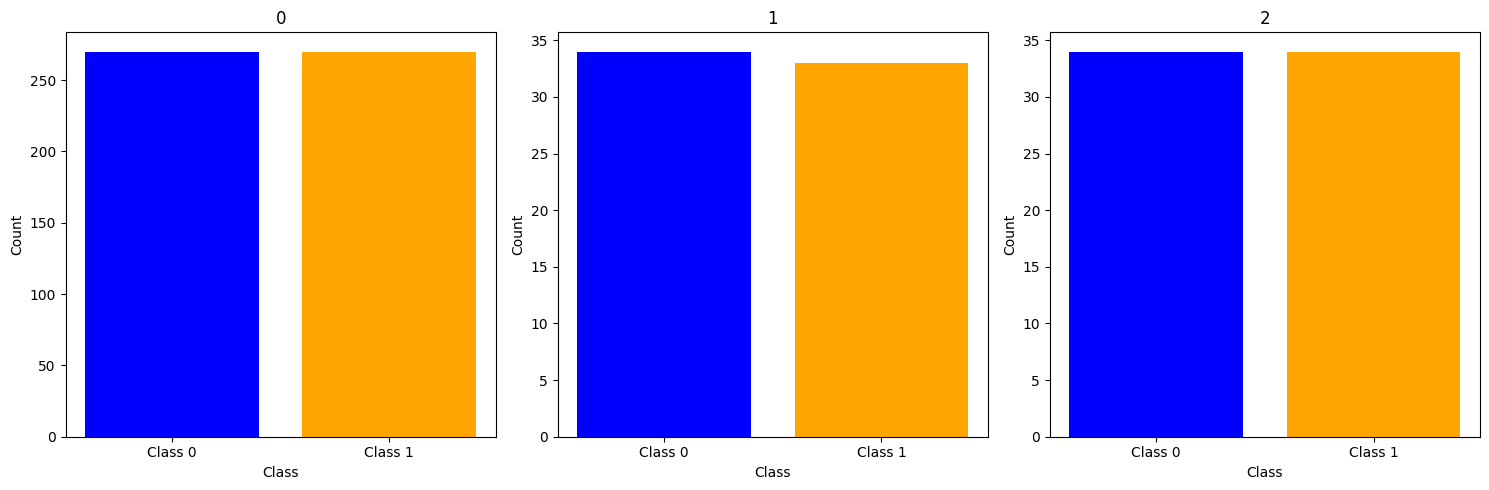

In [17]:
arrays = [y_LDN_train, y_LDN_val, y_LDN_test]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
print('Showing the bar plots of Train Dataset, Validation Dataset, and Test Dataset')
for i, arr in enumerate(arrays):
    class_counts = np.sum(arr, axis=0)
    axes[i].bar(np.arange(len(class_counts)), class_counts, color=['blue', 'orange'])
    axes[i].set_title(f'{i}')
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel('Count')
    axes[i].set_xticks(np.arange(len(class_counts)))
    axes[i].set_xticklabels(['Class 0', 'Class 1'])
plt.tight_layout()
plt.show()